In [ ]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt  
from collections import Counter 
import xgboost as xgb
from xgboost import XGBClassifier
from tqdm import tqdm

In [ ]:
# import dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Documents importants/Academic/MIT/Fall/15_572_Analytics_lab/Google Colab - ALab/Notebooks/src')

In [ ]:
# read csv file
# data = pd.read_csv("/content/drive/MyDrive/Google Colab - ALab/Data/ML_NOAC_NOVA_Extraction_Cleaned_DF3_Full.csv")
data = pd.read_csv("/content/drive/MyDrive/Documents importants/Academic/MIT/Fall/15_572_Analytics_lab/Google Colab - ALab/Data/ML_NOAC_NOVA_Extraction_Cleaned_DF3_Full.csv")

In [ ]:
data.shape

(251234, 16)

In [ ]:
# read file to take sentiment from
sentiment = pd.read_csv("/content/drive/MyDrive/Documents importants/Academic/MIT/Fall/15_572_Analytics_lab/Google Colab - ALab/Data/Sentiment Analysis.csv")

In [ ]:
sentiment.shape

(251230, 3)

In [ ]:
# read file with NN output
class_bert = pd.read_csv("/content/drive/MyDrive/Documents importants/Academic/MIT/Fall/15_572_Analytics_lab/Google Colab - ALab/NLP Models/BERT_final/NN_probabilities_Full.csv")

In [ ]:
class_bert.shape

(251234, 2)

In [ ]:
# read file
class_features = pd.read_csv("/content/drive/MyDrive/Documents importants/Academic/MIT/Fall/15_572_Analytics_lab//Google Colab - ALab/Data/Classification_on_features.csv")

In [ ]:
class_features.shape

(251234, 5)

In [ ]:
# set sentiment and class_features CaseNumber as index in preparation for join
sentiment = sentiment.set_index('CaseNumber').rename(columns={"label": "sentiment_label", "score": "sentiment_score"})
class_features = class_features.set_index('CaseNumber')
class_bert = class_bert.set_index('CaseNumber')

In [ ]:
# map False = 0, True = 1 in all columns
for column in class_features.columns:
  class_features[column] = class_features[column].astype(int)

In [ ]:
# map negative sentiment to 0 and positive to 1
sentiment_pos_neg = np.array([])
for element in sentiment['sentiment_label']:
  if element == 'NEGATIVE':
    sentiment_pos_neg = np.append(sentiment_pos_neg, 0)
  else:
    sentiment_pos_neg = np.append(sentiment_pos_neg, 1)

sentiment['sentiment_label'] = sentiment_pos_neg

In [ ]:
# join the dataframes
data = data.join(sentiment, on = 'CaseNumber')
data = data.join(class_features, on = 'CaseNumber')
data = data.join(class_bert, on = 'CaseNumber')

In [ ]:
# drop Nan just in case there are some
data.dropna(inplace = True)

We see that there are certain Topics that basically have a close to 1 correlation with the output variable

In [ ]:
Counter(data.loc[data["Type"] == 1, "Topics"])

Counter({'T701': 5525, 'T702': 1962, 'T848': 1641, 'T909': 134, 'T700': 223})

In [ ]:
Counter(data.loc[data["Type"] == 0, "Topics"])

Counter({'T035': 420,
         'T847': 1091,
         'T202': 203,
         'T037': 1911,
         'T056': 42,
         'T201': 111,
         'T203': 200,
         'T036': 2704,
         'T013': 1175,
         'T038': 1781,
         'T539': 906,
         'T808': 67,
         'T200': 574,
         'T039': 182,
         'T054': 212,
         'T068': 164,
         'T044': 492,
         'T065': 1250,
         'T004': 37,
         'Complex Request': 173,
         'T048': 76,
         'T875': 1,
         'T043': 74,
         'T854': 37,
         'T069': 151,
         'T842': 2,
         'T019': 11,
         'T050': 112,
         'T057': 18,
         'T042': 69,
         'T018': 553,
         'T005': 14,
         'T062': 38,
         'T701': 9,
         'T052': 69,
         'T866': 1,
         'T317': 5,
         'T040': 14,
         'T844': 38,
         'T030': 1,
         'T049': 37,
         'T940': 101,
         'T928': 38,
         'T067': 45,
         'T850': 12,
         'T031': 187,
 

In [ ]:
# create features with fourth and last word in "TeamName"
data["TeamName_division"] = data["TeamName"].apply(
        lambda x: x.split("-")[3]
    )
data["TeamName_client"] = data["TeamName"].apply(
        lambda x: x.split("-")[-1]
    )

In [ ]:
# remove TeamName
data.drop("TeamName", axis=1, inplace = True)

In [ ]:
data.head()

,index,CaseNumber,Type,Topics,RequesterEmail,EmailObject,LastEmailCCAddress,AttributesURL,ContactAttributesURL,ContactEmail,...,LastEmailContent,sentiment_label,sentiment_score,EmailObjectPreds,LastEmailContentPreds,TeamNamePreds,EmailsPreds,NN_probs,TeamName_division,TeamName_client
2,2,100095395,0,T035,tina@generallogistics.net,AMEND NAM5088900 [ ref:_00D,bookings@generallogistics.net,5005p00002evX4SAAU,0030N00002x1JqPQAU,tina@generallogistics.net,...,hello please split subject line booking to the...,0.0,0.987871,1,0,0,0,0.058365,BKG,PREFERRED
3,3,100097054,0,T847,bookings@delongcompany.com,FW: CMA CGM - Cut-off date cha,usa.cmaexportactive@usa.cma-cgm.com,5005p00002evXIsAAM,0030N00002tXvvIQAS,bookings@delongcompany.com,...,cma cgm cutoff date change at new york ny u up...,0.0,0.948992,0,0,0,0,0.006992,BKG,SPECIALTY
12,12,100109412,0,T035,erica.pavese@theredwoodgroup.com,RE: Detroit to gwangyang REDWO,usa.cmaexportactive@usa.cma-cgm.com,5005p00002evXg4AAE,0030N00003JpqfxQAB,erica.pavese@theredwoodgroup.com,...,hi cma wanted to see if any booking had been s...,0.0,0.656093,0,0,0,0,0.023903,BKG,SPECIALTY
13,13,100109413,0,T035,erica.pavese@theredwoodgroup.com,RE: Detroit to gwangyang REDWO,usa.cmaexportactive@usa.cma-cgm.com,5005p00002evXg5AAE,0030N00003JpqfxQAB,erica.pavese@theredwoodgroup.com,...,hi cma wanted to see if any booking had been s...,0.0,0.656093,0,0,0,0,0.023903,BKG,SPECIALTY
14,14,100109414,0,T035,erica.pavese@theredwoodgroup.com,RE: Detroit to gwangyang REDWO,usa.cmaexportactive@usa.cma-cgm.com,5005p00002evXg6AAE,0030N00003JpqfxQAB,erica.pavese@theredwoodgroup.com,...,hi cma wanted to see if any booking had been s...,0.0,0.656093,0,0,0,0,0.023903,BKG,SPECIALTY


In [ ]:
# work on copy so if we mess up it's ok
df = data.copy()

In [ ]:
# keep only features useful for prediction, work on copy of data
df.drop(["index", "CaseNumber", "Topics", "RequesterEmail", "EmailObject", "LastEmailCCAddress", "AttributesURL", 
         "ContactAttributesURL", "ContactEmail", "LastIncomingEmailContent", "LastEmailContent"], axis = 1, inplace = True)

df.head()

,Type,LastEmailCCAddressCount,CMA_in_cc,CountMailsInConversation,sentiment_label,sentiment_score,EmailObjectPreds,LastEmailContentPreds,TeamNamePreds,EmailsPreds,NN_probs,TeamName_division,TeamName_client
2,0,1,False,3,0.0,0.987871,1,0,0,0,0.058365,BKG,PREFERRED
3,0,1,True,2,0.0,0.948992,0,0,0,0,0.006992,BKG,SPECIALTY
12,0,1,True,2,0.0,0.656093,0,0,0,0,0.023903,BKG,SPECIALTY
13,0,1,True,2,0.0,0.656093,0,0,0,0,0.023903,BKG,SPECIALTY
14,0,1,True,2,0.0,0.656093,0,0,0,0,0.023903,BKG,SPECIALTY


In [ ]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1).drop(feature_to_encode, axis = 1)
    return(res)

In [ ]:
# one-hot encodinc for categorical variables
#df = encode_and_bind(df, "Topics")
df = encode_and_bind(df, "CMA_in_cc")
df = encode_and_bind(df, "TeamName_division")
df = encode_and_bind(df, "TeamName_client")

In [ ]:
df.head()

,Type,LastEmailCCAddressCount,CountMailsInConversation,sentiment_label,sentiment_score,EmailObjectPreds,LastEmailContentPreds,TeamNamePreds,EmailsPreds,NN_probs,...,TeamName_client_USSA,TeamName_client_VANGUARD,TeamName_client_VECONINTER,TeamName_client_VINMAR,TeamName_client_WALMART,TeamName_client_WCR,TeamName_client_WESTROCK,TeamName_client_WILLIAMSSONOMA,TeamName_client_ZESPRI,TeamName_client_ZHENSHI
2,0,1,3,0.0,0.987871,1,0,0,0,0.058365,...,0,0,0,0,0,0,0,0,0,0
3,0,1,2,0.0,0.948992,0,0,0,0,0.006992,...,0,0,0,0,0,0,0,0,0,0
12,0,1,2,0.0,0.656093,0,0,0,0,0.023903,...,0,0,0,0,0,0,0,0,0,0
13,0,1,2,0.0,0.656093,0,0,0,0,0.023903,...,0,0,0,0,0,0,0,0,0,0
14,0,1,2,0.0,0.656093,0,0,0,0,0.023903,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# split into train_valid and test, never look test
train_valid, test = train_test_split(df, test_size = 0.1, random_state = 1, stratify = df["Type"])

If we use cross validation remember to use the whole train_valid

In [ ]:
def TrainValidTestSplit(train_valid):

  train, valid = train_test_split(train_valid, test_size = 0.3, random_state = 1, stratify = train_valid["Type"])

  X_train = train.loc[:, train.columns != "Type"]
  y_train = train["Type"]

  X_valid = valid.loc[:, valid.columns != "Type"]
  y_valid = valid["Type"]

  return train, valid, X_train, X_valid, y_train, y_valid

In [ ]:
def PlotConfusionMatrix(cm):

  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');
  ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 

  plt.show()

In [ ]:
# evaluate model
def EvaluateModel(model, y_pred, y_true):

  PlotConfusionMatrix(confusion_matrix(y_true, y_pred))

  return precision_score(y_true, y_pred), recall_score(y_true, y_pred), confusion_matrix(y_true, y_pred)

In [ ]:
def Threshold(y_true, y_pred):

  pre, rec, t = precision_recall_curve(y_true, y_pred)

  # get threshold that allows for >90%, >95%, >99% precision
  t_90 = t[next(x for x, val in enumerate(pre) if val >= 0.90)]
  t_95 = t[next(x for x, val in enumerate(pre) if val >= 0.95)]
  t_99 = t[next(x for x, val in enumerate(pre) if val >= 0.99)]

  return [t_90, t_95, t_99]


In [ ]:
def GetResults(model, y, pred):
  # create vectors to save results
  precision = np.array([])
  recall = np.array([])
  # understand threshold to have x% precision
  # translate probabilities into predictions
  for t in Threshold(y, pred):
    y_pred = pred > t

    # return in-sample precision and recall
    precision_, recall_, conf_mtx_ = EvaluateModel(model, y_pred, y)

    # append results
    precision = np.append(precision, precision_)
    recall = np.append(recall, recall_)

  # print results
  results = pd.DataFrame({'Precision' : precision, 'Recall' : recall}) 
  print(results)

In [ ]:
# logistic regression model
def LogReg(df):
  
  train, valid, X_train, X_valid, y_train, y_valid = TrainValidTestSplit(df)

  # create model
  model = linear_model.LogisticRegression()

  # fit model
  model.fit(X_train, y_train)

  # make predictions
  pred_valid = model.predict_proba(X_valid)[:,1]

  # get results
  GetResults(model, y_valid, pred_valid)

  return model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


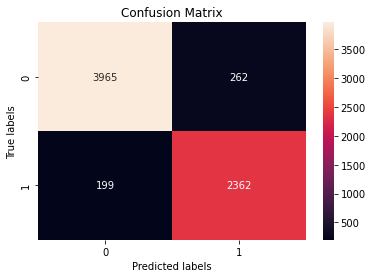

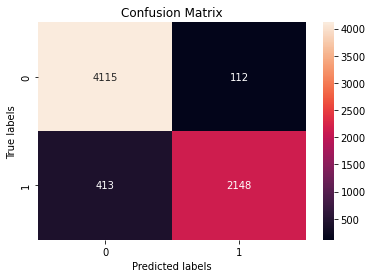

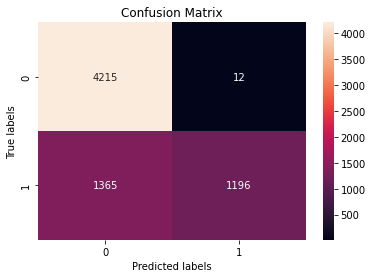

   Precision    Recall
0   0.900152  0.922296
1   0.950442  0.838735
2   0.990066  0.467005


In [ ]:
LogReg_Model = LogReg(train_valid)

In [ ]:
def CART(df):

  # cross-validation, so we keep the entire train-valid data without further splitting
  # still, split X, y
  X = df.loc[:, df.columns != "Type"]
  y = df["Type"]

  # define parameters of the tree
  tree_para = {'criterion': ['gini'],
               'max_depth': range(2, 20, 3),
               'min_samples_split': [2, 5],
               'min_samples_leaf': [2, 5],}

  model = GridSearchCV(DecisionTreeClassifier(random_state = 1), tree_para, cv=5) # verbose = 2 to get messages

  # fit the model
  model.fit(X, y)

  # make predictions
  pred = model.predict_proba(X)[:,1]

  # get results
  GetResults(model, y, pred)

  return model

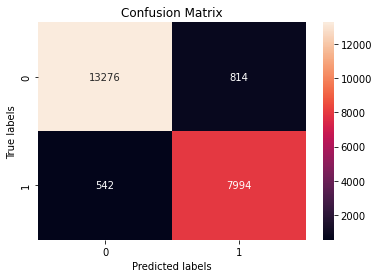

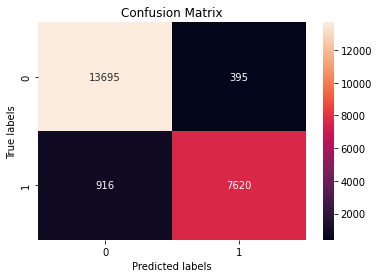

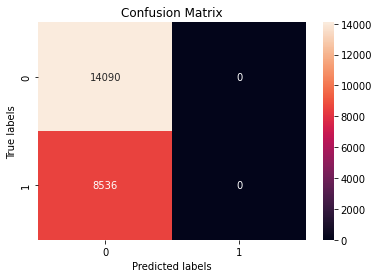

   Precision    Recall
0   0.907584  0.936504
1   0.950717  0.892690
2   0.000000  0.000000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
CART_model = CART(train_valid)

In [ ]:
#from sklearn.tree import plot_tree

#plot_tree(CART_model.best_estimator_, max_depth = 3, label = None)

In [ ]:
# XGBoost
def XGB(df):
  
  # split X, y
  X = df.loc[:, df.columns != "Type"]
  y = df["Type"]

  # define parameters to try
  '''
  xgb_para = {'learning_rate': [0.1],
              'max_depth':range(2, 8, 2),
              'min_child_weight':range(1,6,3),
              'gamma': [i/10.0 for i in range(0,5,2)],
              }
  '''
  xgb_para = {} # using default parameters

  # define the model
  model = GridSearchCV(XGBClassifier(random_state = 1), xgb_para, cv=5) # verbose = 2

  # fit the model
  model.fit(X, y)

  # make predictions
  pred = model.predict_proba(X)[:,1]

  # get results
  GetResults(model, y, pred)

  return model

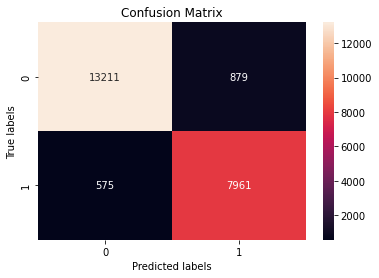

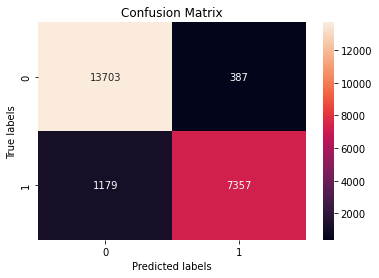

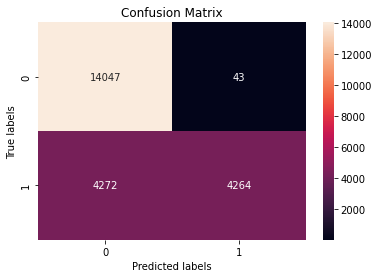

   Precision    Recall
0   0.900566  0.932638
1   0.950026  0.861879
2   0.990016  0.499531


In [ ]:
XGBModel = XGB(train_valid)

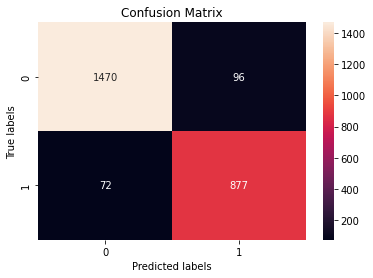

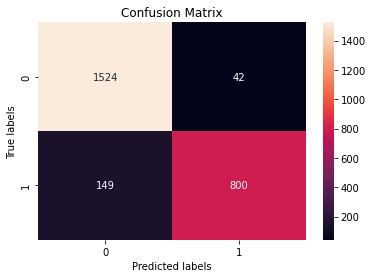

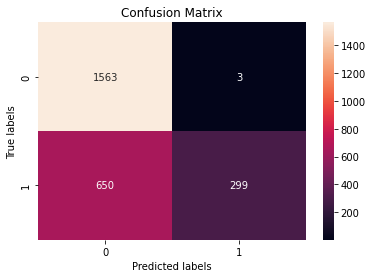

   Precision    Recall
0   0.901336  0.924131
1   0.950119  0.842993
2   0.990066  0.315068


In [ ]:
#######################################
# cheat, predict using XGB on test set # 
#######################################

pred_test = XGBModel.predict_proba(test.loc[:, test.columns != "Type"])[:,1]
y_test = test.loc[:, test.columns == "Type"]

# get results
GetResults(XGBModel, y_test, pred_test)

In [ ]:
# Random Forest
def RF(df):

  # split X, y
  X = df.loc[:, df.columns != "Type"]
  y = df["Type"]

  # define parameters to try
  '''
  rf_para = {'max_depth':range(3,10,2),
             'n_estimators': [100, 200, 500, 1000],
              'min_samples_split': [2, 5],
              }
  '''
  rf_para = {} # using default parameters

  # define the model
  model = GridSearchCV(RandomForestClassifier(random_state = 1), rf_para, cv=5, verbose = 3) # verbose = 2

  # fit the model
  model.fit(X, y)

  # make predictions
  pred = model.predict_proba(X)[:,1]

  # get results
  GetResults(model, y, pred)

  return model


In [ ]:
from utils import *
from nlp_utils import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Probability Threshold:  0.8141666666666666
Accuracy: 0.88
Auc: 0.97
Detail:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     12697
           1       0.98      0.70      0.82      7667

    accuracy                           0.88     20364
   macro avg       0.91      0.85      0.87     20364
weighted avg       0.90      0.88      0.88     20364



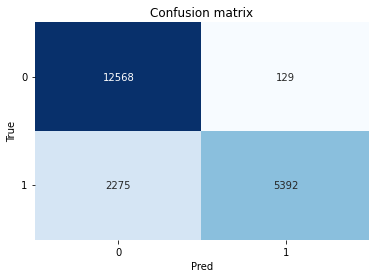

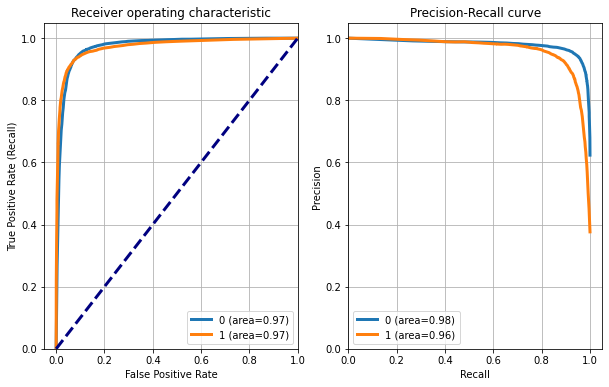

In [ ]:
from sklearn.model_selection import cross_val_score

X = train_valid.loc[:, train_valid.columns != "Type"]
y = train_valid["Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=1)

rf = RandomForestClassifier(random_state = 1)
# scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='precision_macro', verbose=1000)

rf.fit(X_train, y_train)

predicted = rf.predict(X_test)
predicted_prob = rf.predict_proba(X_test)
performance_report(y_test, predicted_prob, 0.975)

In [ ]:
X_train

,LastEmailCCAddressCount,CountMailsInConversation,sentiment_label,sentiment_score,EmailObjectPreds,LastEmailContentPreds,TeamNamePreds,EmailsPreds,NN_probs,TeamName_division_BKG,...,TeamName_client_USSA,TeamName_client_VANGUARD,TeamName_client_VECONINTER,TeamName_client_VINMAR,TeamName_client_WALMART,TeamName_client_WCR,TeamName_client_WESTROCK,TeamName_client_WILLIAMSSONOMA,TeamName_client_ZESPRI,TeamName_client_ZHENSHI
5090,15,1,0.0,0.595452,0,0,0,0,0.275245,0,...,0,0,0,0,0,0,0,0,0,0
154838,6,15,0.0,0.978653,0,0,0,0,0.528721,0,...,0,0,0,0,0,0,0,0,0,0
158113,3,1,0.0,0.998754,1,1,1,1,0.927672,0,...,0,0,0,0,0,0,0,0,0,0
4833,2,1,0.0,0.781481,0,0,0,0,0.007253,0,...,0,0,0,0,0,0,0,0,0,0
157637,1,4,1.0,0.738129,0,0,0,0,0.039031,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158256,7,1,0.0,0.595452,0,0,0,0,0.275245,0,...,0,0,0,0,0,0,0,0,0,0
8058,7,5,0.0,0.940355,0,1,1,1,0.187156,0,...,0,0,0,0,0,0,0,0,0,0
147544,12,5,0.0,0.999536,0,0,0,0,0.734950,0,...,0,0,0,0,0,0,0,0,0,0
147718,2,3,0.0,0.938314,0,0,0,0,0.499674,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pd.set_option('display.max_rows', 500)

a = pd.DataFrame(rf.feature_importances_)
a["feature"] = X_train.columns
a.sort_values(by=[0], ascending=True)

,0,feature
35,0.000000e+00,TeamName_client_ASHLEYFURNITURE
174,0.000000e+00,TeamName_client_PERISHABLES
165,0.000000e+00,TeamName_client_NSVIPSPE
154,0.000000e+00,TeamName_client_MR
153,0.000000e+00,TeamName_client_MOHAWK
149,0.000000e+00,TeamName_client_MICHAELS
140,0.000000e+00,TeamName_client_LOUISDREYFUS
183,0.000000e+00,TeamName_client_RALPHLAUREN
130,0.000000e+00,TeamName_client_KIRKLANDS
186,0.000000e+00,TeamName_client_REDELIVERY


In [ ]:
performance_report(y_test, predicted_prob, 0.7)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.938 total time=   3.7s
[CV 2/5] END ..................................., score=0.939 total time=   3.8s
[CV 3/5] END ..................................., score=0.938 total time=   3.5s
[CV 4/5] END ..................................., score=0.932 total time=   3.7s
[CV 5/5] END ..................................., score=0.941 total time=   3.7s


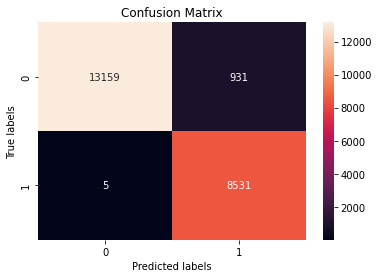

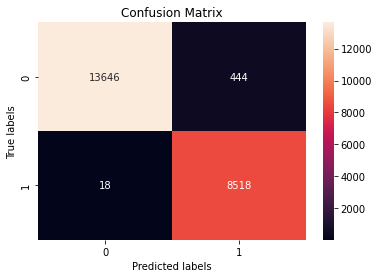

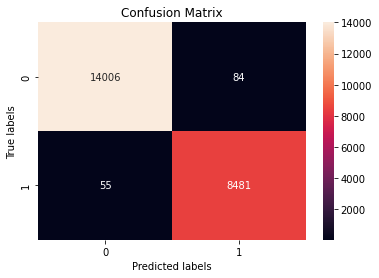

   Precision    Recall
0   0.901606  0.999414
1   0.950457  0.997891
2   0.990193  0.993557


In [ ]:
RFModel = RF(train_valid)

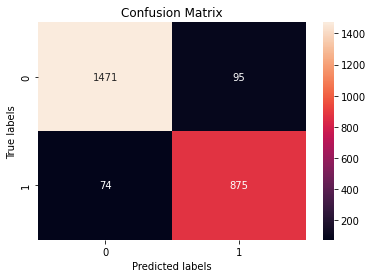

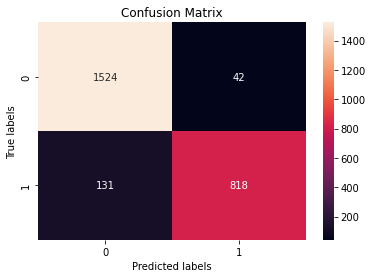

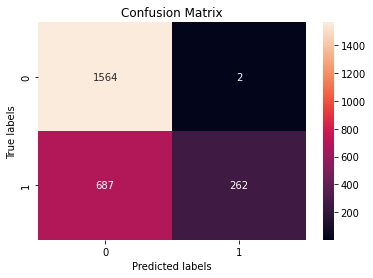

   Precision    Recall
0   0.902062  0.922023
1   0.951163  0.861960
2   0.992424  0.276080


In [ ]:
#######################################
# cheat, predict using RF on test set # 
#######################################

pred_test = RFModel.predict_proba(test.loc[:, test.columns != "Type"])[:,1]
y_test = test.loc[:, test.columns == "Type"]

# get results
GetResults(RFModel, y_test, pred_test)


In [ ]:
# K-nearest neighbors
def KNN(df):

  # split X, y
  X = df.loc[:, df.columns != "Type"]
  y = df["Type"]

  # define parameters to try
  '''
  knn_para = {'n_neighbors': [2,5,10],
              'weights': ['uniform', 'distance'],
              }
  '''
  knn_para = {}

  # define the model
  model = GridSearchCV(KNeighborsClassifier(), knn_para, cv=5) # verbose = 2

  # fit the model
  model.fit(X, y)

  # make predictions
  pred = model.predict_proba(X)[:,1]

  GetResults(model, y, pred)

  return model

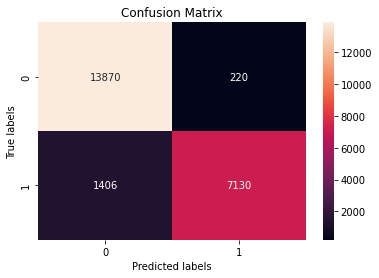

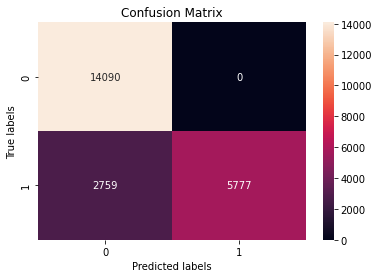

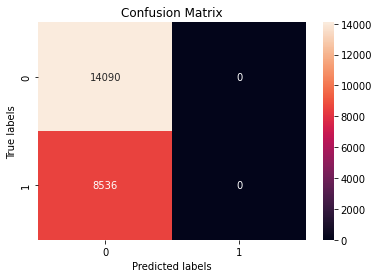

   Precision    Recall
0   0.970068  0.835286
1   1.000000  0.676781
2   0.000000  0.000000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
KNNModel = KNN(train_valid)